<img src="logo.png" align="right" style="float" width="400">
<font color="#EF4123"><h1 align="right">Dude, where's my shared car?</h1></font>

**Jupyter 01 - Mapas y censo de Madrid**
----------------
-----------------------------------------------------------------------
Este código de Python se basa en *geopandas* para cargar mapas geométricos de Madrid y *bokeh* para hacer representaciones interactivas. Cuenta con la siguiente información:
- Mapa topográfico (por vértices/puntos).
- Mapas poligonales de distritos y barrios.
- Información del censo a fecha 1 de Enero de 2018.

In [18]:
from distributed import Client
client = Client(processes=False)
#print(client)

import geopandas as gpd
import numpy as np
import pandas as pd

C:\Users\Miguel\Anaconda3\lib\site-packages\distributed\bokeh\core.py:55: UserWarning: 
Failed to start diagnostics server on port 8787. [WinError 10048] Solo se permite un uso de cada dirección de socket (protocolo/dirección de red/puerto)
  warnings.warn('\n' + msg)


Configuraciones previas: ¿dónde muestro los mapas?

In [19]:
plotear_en_notebook = True # en caso contrario, en un html externo

Datos Geográficos
--------------
Cargamos los ficheros de Vértices, Distritos y Barrios

In [20]:
vertices = gpd.read_file('Datos/datos_vertices_etrs89/datos_vertices_etrs89.shp')
distritos = gpd.read_file('Datos/DISTRITOS_ETRS89/SHP_ETRS89/DISTRITOS.shx')
barrios = gpd.read_file('Datos/BARRIOS_ETRS89/SHP_ETRS89/BARRIOS.shx')

lista_distritos = ['Centro','Arganzuela','Retiro','Salamanca','Chamartín','Tetuán','Chamberí','Fuencarral - El Pardo','Moncloa - Aravaca','Latina','Carabanchel','Usera','Puente de Vallecas','Moratalaz','Ciudad Lineal','Hortaleza','Villaverde','Villa de Vallecas','Vicálvaro','San Blas - Canillejas','Barajas']

#print(barrios.head())
#print(distritos.head())
#print(vertices.head())

Datos del Censo
---------------
Cargamos el censo de 2018

In [21]:
datos_censo_2018 = pd.read_excel('Datos/censo_2018_barrios.xlsx', decimal = ',')
#print(datos_censo_2018.head())
datos_pob_barrios = pd.read_excel('Datos/estadistica_pob.xls', decimal = '.')
#print(datos_pob_barrios.head())

censo_Madrid_2018 = datos_censo_2018[datos_censo_2018['NOMBRE']=='Ciudad de Madrid']
censo_2018 = datos_censo_2018[datos_censo_2018['NOMBRE']!='Ciudad de Madrid']
censo_distritos = censo_2018[censo_2018['NOMBRE'].isin(lista_distritos)]
censo_barrios = censo_2018[~censo_2018['NOMBRE'].isin(lista_distritos)]

#print(censo_Madrid_2018)
#print(censo_distritos.describe())
#print(censo_barrios.describe())
#print(censo_distritos.describe())

Merge de las tablas

In [22]:
barrios = barrios.merge(censo_barrios, on='NOMBRE')
barrios = barrios.merge(datos_pob_barrios, on='NOMBRE')
#print(barrios.head())
#print(barrios.columns.tolist())

distritos = distritos.merge(censo_distritos, on='NOMBRE')
#print(distritos.head())

Generación de datos de Demanda
------------------------------

Generamos series de datos "de juguete" para la demo

In [23]:
nrow, ncol = barrios.shape
#print(nrow)
barrios['DEMANDA'] = np.round(np.abs(np.random.randn(nrow))*254)

my_array = barrios['DEMANDA']
total_demanda = my_array.sum()
#print(total_demanda)

#print(barrios.head())

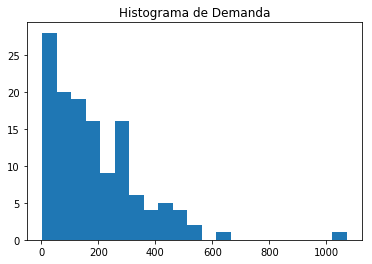

In [24]:
import matplotlib.pyplot as plt

plt.hist(my_array, bins=21)  # arguments are passed to np.histogram
plt.title("Histograma de Demanda")
plt.show()

In [25]:
distritos['DEMANDA_AGREGADA'] = np.nan
nrow, ncol = distritos.shape
#print(nrow)

for l in lista_distritos:
    barrio_aux = barrios.loc[barrios['NOMDIS'] == l]
    indices_aux = distritos.loc[distritos['NOMBRE'] == l].index.values
    for i in indices_aux:
        distritos.loc[i,'DEMANDA_AGREGADA']=barrio_aux['DEMANDA'].sum()
    
#print(distritos.head())

Bokeh
------

Usaremos el paquete *Bokeh* para tener representaciones interactivas

In [26]:
from bokeh.palettes import viridis,inferno,grey, cividis, plasma, magma
from bokeh.io import output_notebook
from bokeh.models import GeoJSONDataSource, HoverTool, CategoricalColorMapper, LinearColorMapper
from bokeh.plotting import figure, show
from bokeh.io import output_file, show
from bokeh.models import ColorBar
from bokeh.models import ColumnDataSource
from bokeh.models.widgets import CheckboxGroup

In [27]:
color_mapperLinear = LinearColorMapper(viridis(256))

color_bar = ColorBar(color_mapper=color_mapperLinear,
                     location=(0, 0),
                     label_standoff=12)

*Representación de puntos:* 
nos puede servir para la demo de la localización de la flota

In [28]:
geo_source_puntos = GeoJSONDataSource(geojson=vertices.to_json())

In [29]:
# etiquetas
hover_puntos = HoverTool(point_policy='follow_mouse')
hover_puntos.tooltips = [('Vértices', '@Vertice'), ('Situación', '@Situacion')]

# plot
puntos = figure(plot_width=750, plot_height=750,background_fill_color="lightgrey")
puntos.circle(x='x', y='y', size=4, alpha=0.7, source=geo_source_puntos)
puntos.add_tools(hover_puntos)
puntos.title.text = "Madrid: puntos"
puntos.xaxis.visible = False
puntos.yaxis.visible = False
puntos.grid.visible = False
#puntos.add_layout(color_bar, 'right')

# mostrar en notebook o en html
if (plotear_en_notebook):
    output_notebook()
else:
    output_file("mapa_Madrid_puntos.html")
    
show(puntos)

Loading BokehJS ...

*Representación de polígonos-barrios:* 
nos puede servir para la demo de la localización de la población en Madrid

In [30]:
geo_source_barrios = GeoJSONDataSource(geojson=barrios.to_json())

In [31]:
# lista de Distritos
carrier_selection = CheckboxGroup(labels=lista_distritos, active = [0, 1])

# etiquetas
hover_barrios = HoverTool(point_policy='follow_mouse')
hover_barrios.tooltips = [('Barrio', '@NOMBRE'), ('Distrito', '@NOMDIS'), ('Densidad', '@densidad')]

# plot
barrios = figure(plot_width=750, plot_height=750,background_fill_color="lightgrey")
barrios.patches(xs='xs', ys='ys', alpha=0.7, source=geo_source_barrios, color={'field': 'densidad', 'transform': color_mapperLinear})
barrios.add_tools(hover_barrios)
barrios.title.text = "Madrid: densidad por barrios (Habitantes/Ha.)"
barrios.xaxis.visible = False
barrios.yaxis.visible = False
barrios.grid.visible = False
barrios.add_layout(color_bar, 'right')

# mostrar en notebook o en html
if (plotear_en_notebook):
    output_notebook()
else:
    output_file("mapa_Madrid_barrios.html")
    
show(barrios)

Loading BokehJS ...

*Representación de polígonos-distritos de la Comunidad:* 
nos puede servir para la demo de la localización de la población fuera de Madrid Capital

In [32]:
geo_source_dist = GeoJSONDataSource(geojson=distritos.to_json())

In [33]:
color_bar = ColorBar(color_mapper=color_mapperLinear,
                     location=(0, 0),
                     label_standoff=12)

In [34]:
# etiquetas
hover_distritos = HoverTool(point_policy='follow_mouse')
hover_distritos.tooltips = [('Distrito', '@NOMBRE'), ('Densidad', '@densidad')]

# plot
distritos = figure(plot_width=750, plot_height=750,background_fill_color="lightgrey")
distritos.patches(xs='xs', ys='ys', alpha=0.7, source=geo_source_dist, color={'field': 'densidad', 'transform': color_mapperLinear})
distritos.add_tools(hover_distritos)
distritos.title.text = "Madrid: densidad por distritos (Habitantes/Ha.)"
distritos.xaxis.visible = False
distritos.yaxis.visible = False
distritos.grid.visible = False
distritos.add_layout(color_bar, 'right')

# mostrar en notebook o en html
if (plotear_en_notebook):
    output_notebook()
else:
    output_file("mapa_Madrid_distritos.html")
show(distritos)

Loading BokehJS ...